# CDIPpy Example - Wave Spectrum 2D
The following example runs an application of the [CDIPpy](https://ucsd-sio-cdip.github.io/CDIPpy/quickstart/) python library to create a 2D Polar plot of Energy Spectrum, based on Frequency bands (64) and Directions (0-360).  Data are from the CDIP Maximum Entropy Method (MEM) 2D Energy Spectrum (click [here](http://cdip.ucsd.edu/data_access/MEM_2dspectra.cdip) for an explanation of a MEM2D). 

1) read in CDIP station metadata,
2) find closest spectral record based on user start time,
3) remotely access MEM2D data,
4) plot energy density as polar plot based on frequency and direction.


## Import Libraries

Start by importing the necessary python packages and CDIPPY module

In [114]:
import netCDF4
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
import requests
import time
import calendar
import re
from io import StringIO

# CDIP imports
import cdippy
from cdippy.stndata import StnData

## Initialize CDIPpy input parameters
* Supply CDIP station id
* Start date (YYYYMMDDHH)
* End date
* Station parameters

In [148]:
##- Initialize station id, start/end date, and parameters
##- CDIP interactive Mem2D script is only limited to last 7 days online
stn = '067'
now = dt.datetime.now()
sdate = now.strftime("%Y%m%d")+"0000"
edate = now.strftime("%Y%m%d")+"0200"
params = ['waveFrequency','waveTime']

## Data Access

* Use cdippy.stndata function StnData(stn)
* Returns StnData object
* Access station metadata about individual stations deployments

In [149]:
##- Get Station Dataset object
stn_data = cdippy.stndata.StnData(stn)

##- Get metadata (i.e. information about individual deployments)
meta = stn_data.get_stn_meta()
stn_name = meta['metaStationName']
print(stn_name)

SAN NICOLAS ISLAND, CA BUOY - 067p1


## Figure out closest spectral record to given start time

In [193]:
##- Use CDIPPY to convert input start/end date strings to datetime objects
start = cdippy.utils.cdip_datetime(sdate)
end = cdippy.utils.cdip_datetime(edate)

##- Grab data using 'get_series' function
data = stn_data.get_series(start, end, params)
data.keys()

dict_keys(['waveTime', 'waveFrequency'])

## Convert waveTimes to Datetime object

In [194]:
## Convert wave times to datetime objects (currently integers)
##- Convert times to datetime objects
wT = [cdippy.utils.timestamp_to_datetime(x) for x in data['waveTime']]

In [195]:
## Find closest value in data array to start time (if more than one record returned)
def find_nearest(array, value):
    idx = (np.abs(array - value)).argmin()
    return idx

idx = find_nearest(np.array(wT),start)
neardatestr = wT[idx].strftime("%Y%m%d%H%M")
neardatestr

'202506220000'

## Data - MEM 2D Spectrum
* Make request from external script to retrieve 2D spectra
* Read and parse data as text from CDIP MEM data access page
* Convert data to Pandas dataframe
* Assign columns to waveFrequency variable


In [196]:
url_mem2d = 'http://cdip.ucsd.edu/data_access/MEM_2dspectra.cdip?sp' + stn + '01' + neardatestr

Open MEM2D data as text file, remove formatting, and split into individual rows

In [236]:
response = requests.get(url_mem2d)

# Raise an error if the request fails
response.raise_for_status()

data_text = response.text.split("\n")

# Extract contents from <pre>...</pre> block as text string
match = re.search(r"<pre>(.*?)</pre>", response.text, re.DOTALL)
data_text = match.group(1)

# Now split records by new line
lines = [ line for line in data_text.strip().splitlines() ]

Create a new array 
* Split lines into an array called Edarray of shape (frequencies=64, directions=72)
* Append the first colum of 'Ed_array' to the end of 'Ed_array' so that dimensions are (64L,73L), and the last column connects back to the first column. This allows the polar plot to call all 72 (5-degree bin) columns of real data when plotting the colormesh.

In [221]:
# Iterate over text lines, parse, and append to array called data2
data2 = []
for item in lines:
    line = item.strip().split()
    data2.append(line)

# Append another column to directions to allow for seamless plotting 
#data = filter(None,data)
Edarray = np.asarray(data2,dtype=object)
Ednew = np.append(Edarray,Edarray[:,0:1],1)
Ednew = Ednew.astype(float)
Ednew.shape

(64, 73)

### Dmean and Fq Variables

Create Degrees ('Dmean') and Frequency ('Fq') variables to use in plotting Energy Density

* Extract Frequency variable from NetCDF, to use as 'Fq' array
* Create manually-specified Degrees ('Dmean') list, of 5-degree intervals from 0-360

In [222]:
# Fq = np.asarray(np.arange(0.03,0.59,0.01)) # Use this Frequency range option when calling the 'even' option for a station
Fq = data['waveFrequency']
Fq

Dmean = np.asarray(np.arange(2.5,367.5,5))

# Convert 'Dmean' from degrees to radians
rad_convert = (np.pi/180)
Dmean_rad = [d*rad_convert for d in Dmean]

In [223]:
Edmax = float(np.amax(Ednew))
Edfloat

0.8352832

## Plot Polar Spectrum
* Specify radial and angular axes of polar plot
  * 'radii' = Fq array
  * 'thetas' = Dmean_rad array
* Define colormesh range
* Change 'thetas' alignment so that 0 Degrees is at the top
* Apply a colormesh (contourf) of Energy Density data to polar plot
* Add colorbar and titles

/var/folders/k9/408fbh9d79z7ys6nx8_bcq4m0000gn/T/ipykernel_92385/2932952415.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ylabels)


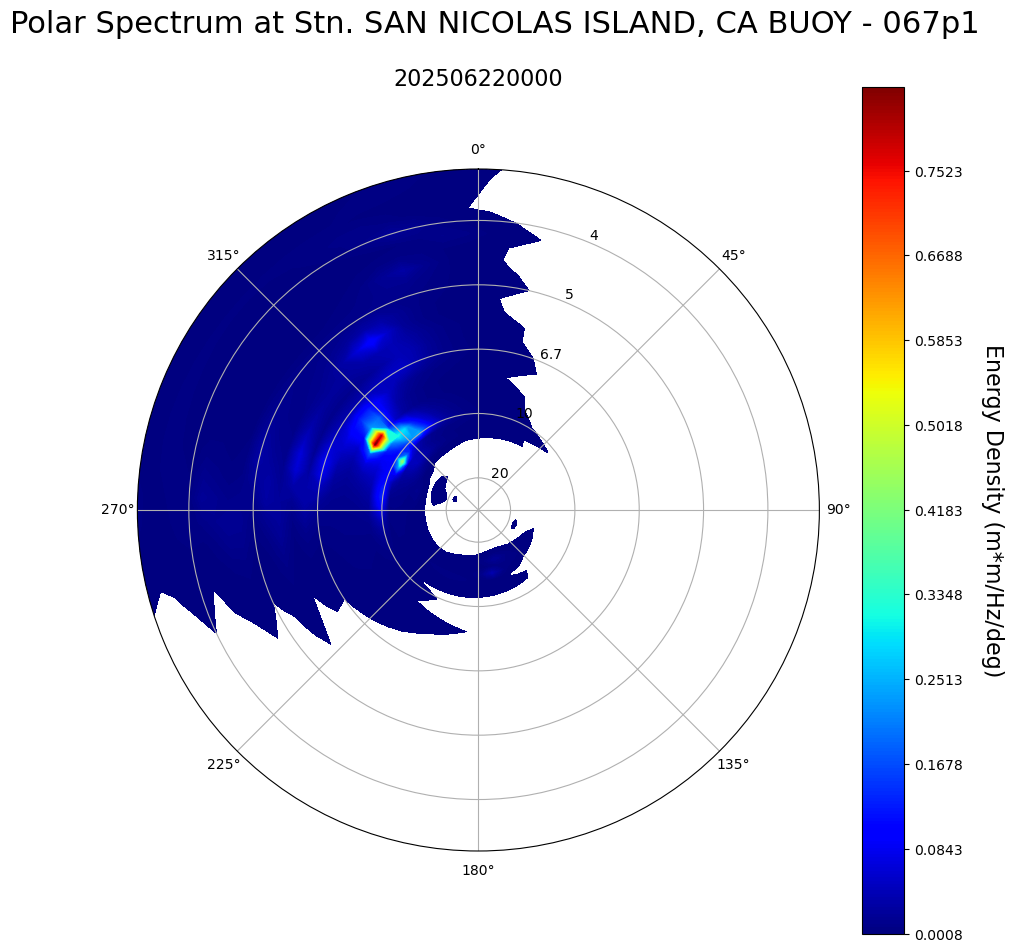

In [235]:
# Create figure and specify figure size
fig = plt.figure(figsize=(11,11))

radii = Fq[0:35] # Only call frequency bands > 0.3 Hz
thetas = Dmean_rad[:]

## Color-scale
# contour_levels = np.arange(0.00,0.1,0.0001) # Manually set colorbar min/max values
#contour_levels = np.arange(Edmax/1000,Edmax/2,0.0001) # Automatically set colorbar min/max values based on 'Ed'
contour_levels = np.arange(Edmax/1000,Edmax,0.0001) # Automatically set colorbar min/max values based on 'Ed'

ax = plt.subplot(111, polar=True)
ax.set_theta_direction(-1)
ax.set_theta_zero_location("N")
ylabels = ([20,10,6.7,5,4])
ax.set_yticklabels(ylabels)

colorax = ax.contourf(thetas, radii, Ednew[0:35],contour_levels,cmap='jet')
#colorax = ax.contourf(thetas, radii, Ednew[0:35],cmap='jet')

## Set titles and colorbar
plt.suptitle('Polar Spectrum at Stn. ' + stn_name, fontsize=22, y=0.95, x=0.45)
plt.title(sdate, fontsize=16, y=1.11)

cbar = fig.colorbar(colorax)
cbar.set_label('Energy Density (m*m/Hz/deg)', rotation=270, fontsize=16)
cbar.ax.get_yaxis().labelpad = 30

degrange = range(0,360,30)
#lines, labels = plt.thetagrids(degrange, labels=None, frac = 1.07)


